In [87]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import scipy.sparse as sp
#from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import scipy.optimize as sop
import seaborn
import random


# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF

### Generate Data

In [88]:
def gen_data():
    # generates testing data
    test_h = sp.random(4,52, density = 0.07).A
    
    # make sure the rows aren't too correlated with each other and that there are no zero rows
    while np.linalg.norm(np.corrcoef(test_h) - np.identity(4)) > 0.2 or np.where(np.sum(test_h, axis = 1) == 0)[0].size != 0:
        test_h = sp.random(4,52, density = 0.07).A
     

    for g in range(len(test_h)):
        scal = test_h[g,:].sum()
        test_h[g,:] /= scal

        
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,300)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    
    #W = normalize(np.array([y1, y2, y3, y4]).T, axis =0)
    W = np.array([y1, y2, y3, y4]).T
    W = pd.DataFrame(W)
    W /= W.max().max()

    return W,H

In [89]:
W,H = gen_data()

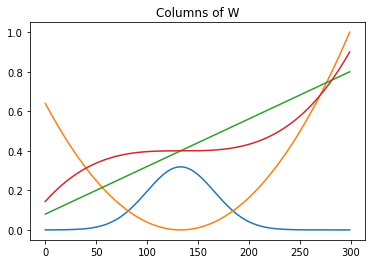

In [90]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

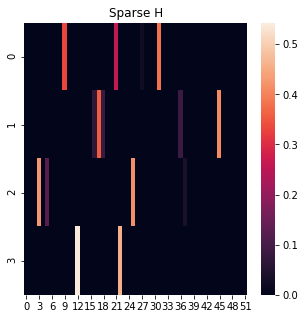

In [91]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [92]:
# sparseness of H
def h_sparseness(h):
    h_sparse = 0
    for row in h.index:
        rh = np.array(h.loc[row,:])
        sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
        sp /= (math.sqrt(len(rh)) - 1)
        h_sparse += sp
    
    h_sparse /= len(h.index)
    
    return h_sparse

In [93]:
h_sparse = h_sparseness(H)

In [94]:
np.corrcoef(H)

array([[ 1.        , -0.06415494, -0.05871573, -0.05002961],
       [-0.06415494,  1.        , -0.05975487, -0.05091502],
       [-0.05871573, -0.05975487,  1.        , -0.04659832],
       [-0.05002961, -0.05091502, -0.04659832,  1.        ]])

In [95]:
pd.DataFrame(np.corrcoef(W.T))

,0,1,2,3
0,1.000000,-0.734892,-0.154151,-0.219918
1,-0.734892,1.000000,0.394179,0.575946
2,-0.154151,0.394179,1.000000,0.897423
3,-0.219918,0.575946,0.897423,1.000000


### Preliminaries

In [96]:
def plotter(data, out_W,out_H, K_in = None, title = " "):
    # plot columns of W
    fix, ax = plt.subplots(1, 2, figsize = (10,5))
    for col in out_W:
        ax[0].plot(out_W.loc[:,col])
        ax[1].plot(W.loc[:,col])

    ax[0].set_title("W output for " + str(title))
    ax[1].set_title("Original columns of W")
    
    # plot heatmap of H
    fig, ax = plt.subplots(1, 2, figsize = (10,5))
    seaborn.heatmap(out_H, square = False, cbar = True, ax = ax[0])
    ax[0].set_title("H output for " + str(title))
    seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
    ax[1].set_title("Original H")
    
    plt.show()
    
    if K_in is None:
        print(title + "error on W: ", np.linalg.norm(W - out_W))
        print(title + "error on H: ", np.linalg.norm(H - out_H))
        print(title + "error on X: ", np.linalg.norm(data - np.dot(out_W, out_H)))
    else:
        print(title + "error on W: ", np.linalg.norm(W - out_W))
        print(title + "error on H: ", np.linalg.norm(H - out_H))
        print(title + "error on D: ", np.linalg.norm(data - np.dot(out_W, np.dot(out_H,K_in))))
    print()

In [97]:
def reorder(w,h,x,v, err = False, err_val = 0.5):
    '''
    her = np.linalg.norm(np.corrcoef(h) - np.identity(4))
    ver = np.linalg.norm(np.corrcoef(v) - np.identity(4))
    print(her)
    print(ver)
    if ver > her + 0.2:
        pass
        #raise ValueError('Rows of V are too correlated')
    '''
    if err:
        vcor = np.corrcoef(v)
        for i in range(vcor.shape[0]):
            for j in range(vcor.shape[1]):
                if i != j and ((vcor[i][i] - vcor[i][j]) < err_val or (vcor[j][j] - vcor[i][j]) < err_val):
                    raise ValueError("Rows of V are too correlated")

    hv = np.ma.corrcoef(h, v)[0:4,4:]
    horder, vorder = sop.linear_sum_assignment(hv, maximize = True)
    
    wx = np.ma.corrcoef(w,x, rowvar = False)[4:,0:4]
    worder, xorder = sop.linear_sum_assignment(wx, maximize = True)

    #if not np.array_equal(vorder, xorder):
    #    raise ValueError("ordering is unclear")

    x = x[:,vorder]
    v = v[vorder]
    return x,v

In [98]:
def diffn_plot(w, h, lap, beta_vals, iters = 1000, algorithm = 'MultUpdate', sparseness = None, lambda_v = None, beta = None, eta = None, err = True, err_val = 0.2):
    # plot the diffusion NMF results over a range of beta values
    # parameters include original w and h, the laplacian, desired level of sparseness, total iterations for NMf
    # and options for a projection version of the algorithm and an alternating least squares version
    I = np.identity(len(lap))
    for beta in beta_vals:
            Kinv = I + beta * lap
            K = np.linalg.inv(Kinv)
                
            D = np.dot(w, np.dot(h, K))
            print("K Condition Number : " + str(np.linalg.cond(K)))

            differ = DiffusionNMF(D, K, ncomponents = 4, iterations = iters, tol = 1e-20)
            differ.solver(algorithm, sparseness, lambda_v, beta, eta)
                
            diffX,diffV = reorder(w,h,differ.X, differ.V, err = err, err_val = err_val)
            diffX = pd.DataFrame(diffX)
            diffV = pd.DataFrame(diffV)

            plotter(D, diffX, diffV, K_in = K, title = "Diffusion NMF @ beta = " + str(beta) + " ")
            
    return diffX, diffV

In [99]:
I = np.identity(np.dot(W,H).shape[1])

In [100]:
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

In [101]:
Ks = np.linalg.inv(I + 3*state_L)

### Reordering Output

K Condition Number : 30.871282980836465


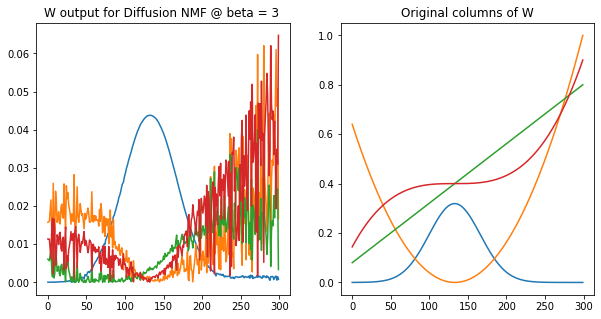

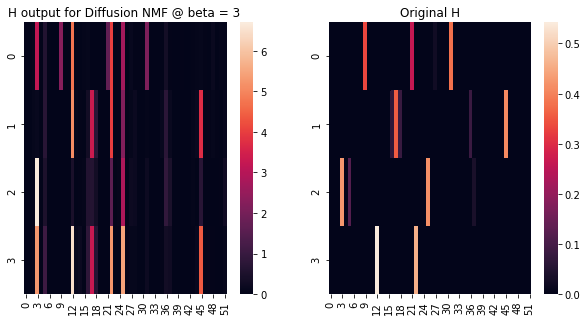

Diffusion NMF @ beta = 3 error on W:  13.205995149404895
Diffusion NMF @ beta = 3 error on H:  18.304698633238594
Diffusion NMF @ beta = 3 error on D:  0.0902238925919702



In [102]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultUpdate',sparseness = None, err = False, err_val = 0.01)

K Condition Number : 30.871282980836465


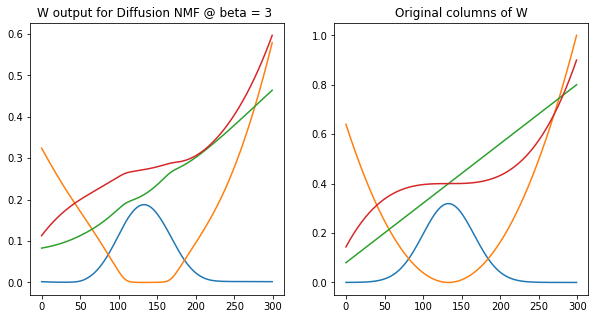

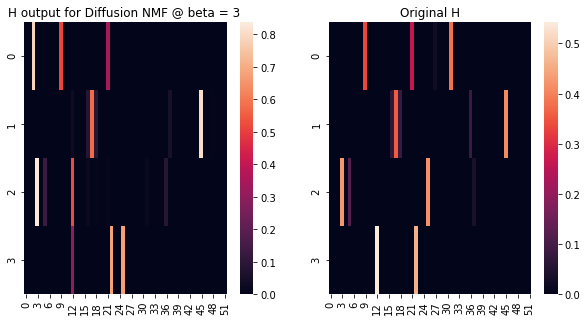

Diffusion NMF @ beta = 3 error on W:  5.500939910124293
Diffusion NMF @ beta = 3 error on H:  1.482130017697143
Diffusion NMF @ beta = 3 error on D:  0.12319211803668337



In [103]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'HoyerP',sparseness = h_sparse, err = True,err_val = 0.1)

K Condition Number : 30.871282980836465


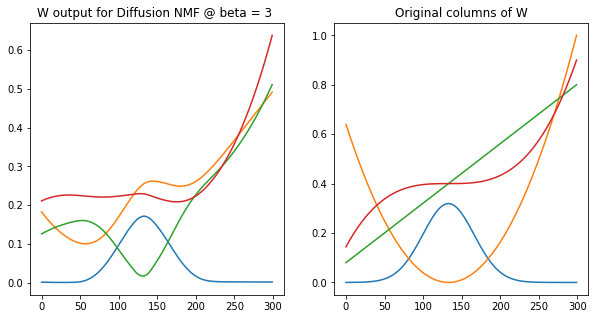

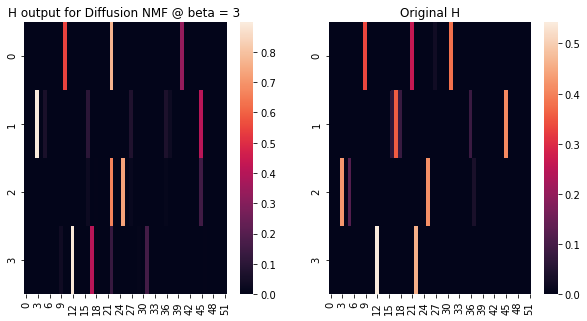

Diffusion NMF @ beta = 3 error on W:  7.10310341512373
Diffusion NMF @ beta = 3 error on H:  1.859437968894756
Diffusion NMF @ beta = 3 error on D:  0.1987782989115371



In [104]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultProj', sparseness = h_sparse, err = True, err_val = 0.2)

K Condition Number : 10.95709432694549


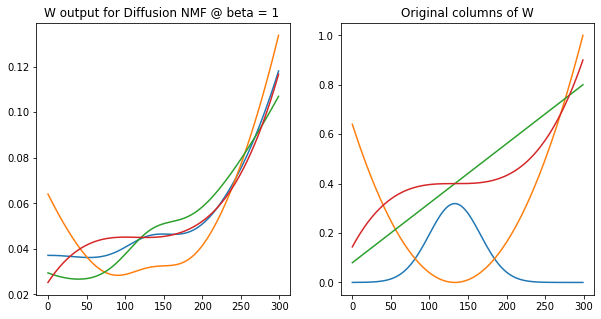

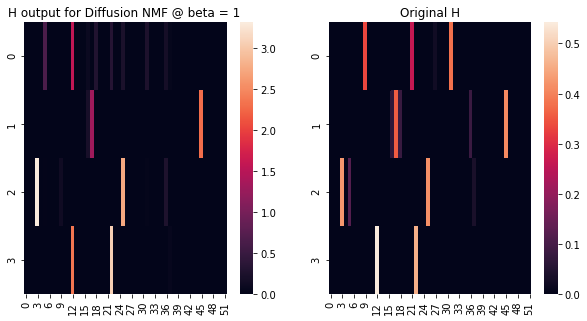

Diffusion NMF @ beta = 1 error on W:  11.969231783947405
Diffusion NMF @ beta = 1 error on H:  5.6422630996306085
Diffusion NMF @ beta = 1 error on D:  0.7542007521936729



In [105]:
X,V = diffn_plot(W,H,state_L, [1], iters = 5000, algorithm = 'HoyerS', lambda_v = 0.1, err = False, err_val = 0.2)

K Condition Number : 30.871282980836465


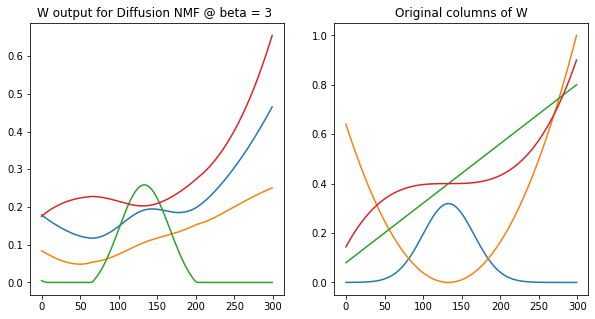

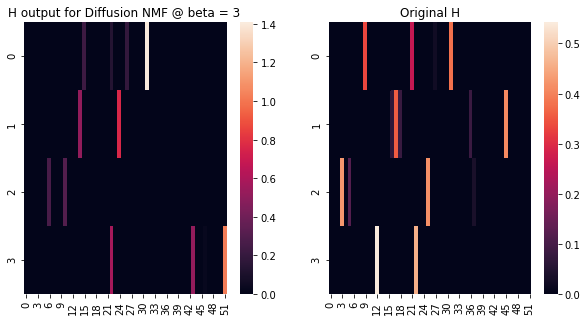

Diffusion NMF @ beta = 3 error on W:  10.19620462339095
Diffusion NMF @ beta = 3 error on H:  2.162699867020008
Diffusion NMF @ beta = 3 error on D:  0.7224351390679773



In [106]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'TwoPhase', sparseness = h_sparse, err = True, err_val = 0.2)

In [107]:
%%capture
def dist_tester(err_val, tries):
    multc = 0
    hoyerpc = 0
    multpc = 0
    hoyersc = 0
    twopc = 0
    for run in range(tries):
        try:
            X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultUpdate',sparseness = None, err = True, err_val = err_val)
            multc += 1
        except ValueError:
            pass
        try:
            X,V = diffn_plot(W,H,state_L, [3], algorithm = 'HoyerP',sparseness = h_sparse, err = True, err_val = err_val)
            hoyerpc += 1
        except ValueError:
            pass
        try:
            X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultProj', sparseness = h_sparse, err = True, err_val = err_val)
            multpc += 1
        except ValueError:
            pass
        try:
            X,V = diffn_plot(W,H,state_L, [1], iters = 1000, algorithm = 'HoyerS', lambda_v = 1, err = True, err_val = err_val)
            hoyersc += 1
        except ValueError:
            pass
        try:
            X,V = diffn_plot(W,H,state_L, [3], algorithm = 'TwoPhase', sparseness = h_sparse, err = True, err_val = err_val)
            twopc += 1
        except ValueError:
            pass
        
    return [multc, hoyerpc, multpc, hoyersc, twopc]

In [108]:
%%capture
resr = dist_tester(0.5,20)

Text(0.5, 1.0, '# of runs where row-wise correlation on V is distinct')

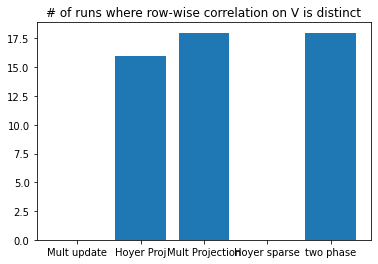

In [109]:
plt.bar(list(range(5)), resr, tick_label = ['Mult update', 'Hoyer Proj', 'Mult Projection', 'Hoyer sparse', 'two phase'])
plt.title('# of runs where row-wise correlation on V is distinct')

### Comparing algorithms

In [110]:
def correlation(x, y, axis = 1):
    # computes the correlation between matrices x and y
    summer = 0
    if axis == 0:
        num_tot = len(x.T)
        for r in range(len(x.T)):
            corr = np.corrcoef(x.T[r], y.T[r])[0][1]
            if not np.isnan(corr):
                summer += corr
            else:
                if np.equal(x.T[r], y.T[r]).all():
                    summer += 1
                else:
                    summer += 0

        cor_avg = summer / num_tot
        return cor_avg
    else:
        num_tot = len(x)
        for r in range(len(x)):
            corr = np.corrcoef(x[r], y[r])[0][1]
            if not np.isnan(corr):
                summer += corr
            else:
                if np.equal(x.T[r], y.T[r]).all():
                    summer += 1
                else:
                    summer += 0
                
        cor_avg = summer / num_tot
        return cor_avg

In [111]:
def comparer(d,w,h,x,v,k):
    res1 = []
    res2 = []

    hk = np.dot(h, k)
    vk = np.dot(v, k)
    # Normal errors
    res1.append(np.linalg.norm(d - np.dot(x, np.dot(v, k))) / np.linalg.norm(d))
    try:
        res1.append(np.linalg.norm(w - x) / np.linalg.norm(w))
        res1.append(np.linalg.norm(hk - vk) / np.linalg.norm(hk))
    except:
        res1.append(np.nan)
        res1.append(np.nan)

    # correlation
    d_test = np.dot(x, np.dot(v, k))
    res2.append(correlation(d, d_test, axis = 0))
    try:
        res2.append(correlation(w.to_numpy(), x, axis = 0))
        res2.append(correlation(hk, vk, axis = 1))
    except:
        res2.append(np.nan)
        res2.append(np.nan)
    
    return res1, res2

In [112]:
def rescale(x,v,k):
    v_diag = []
    x = np.copy(x).astype('float')
    v = np.copy(v).astype('float')
    vk = np.dot(v, k)
    for row in range(len(vk)):
        #v_diag.append(vk[row].sum())
        fact = vk[row,:].sum()
        v[row,:] /= fact
        x[:,row] *= fact
    '''  
    s = np.diag(v_diag)
    try:
        s_inv = np.linalg.inv(s)
    except:
        print(s)
        print(pd.DataFrame(s))
    '''
    #return np.dot(x, s), np.dot(s_inv, v)
    return x, v
    
    

In [113]:
def test_algs(d, w, h, K_b, sparseness,rank = 4,lambda_v = None, iters = 1000, noise = None):
    # for comparing the different algorithms
    #K_b = np.linalg.inv(I + beta * l)
    if lambda_v is None:
        lambda_v = sparseness / 2

    # algorithm 1 -- multiplicative update (no sparse constraint)
    if noise is not None:
        alg1 = DiffusionNMF(noise, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    else:
        alg1 = DiffusionNMF(d, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    alg1.solver('MultUpdate')
    rx, rv = reorder(w,h,alg1.X, alg1.V)
    rx, rv = rescale(rx, rv, K_b)
    alg1_errs, alg1_corrs = comparer(d, w, h, rx, rv, K_b)
    

    # algorithm 2 -- modified Hoyer algorithm
    if noise is not None:
        alg2 = DiffusionNMF(noise, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    else:
        alg2 = DiffusionNMF(d, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    alg2.solver('HoyerP', sparseness = sparseness)
    rx, rv = reorder(w,h,alg2.X, alg2.V)
    rx, rv = rescale(rx, rv, K_b)
    alg2_errs, alg2_corrs = comparer(d, w, h, rx, rv, K_b)
    

    # algorithm 3 -- projected Multiplicative update
    if noise is not None:
        alg3 = DiffusionNMF(noise, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    else:
        alg3 = DiffusionNMF(d, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    alg3.solver('MultProj', sparseness = sparseness)
    rx, rv = reorder(w,h,alg3.X, alg3.V)
    rx, rv = rescale(rx, rv, K_b)
    alg3_errs, alg3_corrs = comparer(d, w, h, rx, rv, K_b)
    
    
    # algorithm 4 -- Hoyer sparse coding
    if noise is not None:
        alg4 = DiffusionNMF(noise, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    else:
        alg4 = DiffusionNMF(d, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    alg4.solver('HoyerS', lambda_v = lambda_v)
    rx, rv = reorder(w,h,alg4.X, alg4.V)
    rx, rv = rescale(rx, rv, K_b)
    alg4_errs, alg4_corrs = comparer(d, w, h, rx, rv, K_b)
    

    # algorithm 5 -- two phase algorithm
    if noise is not None:
        alg5 = DiffusionNMF(noise, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    else:
        alg5 = DiffusionNMF(d, K_b, ncomponents = rank, iterations = iters, tol = 1e-20)
    alg5.solver('TwoPhase', sparseness = sparseness)
    rx, rv = reorder(w,h,alg5.X, alg5.V)
    rx, rv = rescale(rx, rv, K_b)
    alg5_errs, alg5_corrs = comparer(d, w, h, rx, rv, K_b)

    return np.array([alg1_errs, alg2_errs, alg3_errs, alg4_errs, alg5_errs]), np.array([alg1_corrs, alg2_corrs, alg3_corrs, alg4_corrs, alg5_corrs])

In [114]:
def noiser(matr, std_dev = None):
    # add noise to a matrix using gaussian random samples
    matr = np.matrix.copy(matr)
    if std_dev is None:
        std_dev = matr.std()
    '''
    noises = int(changes * matr.shape[0] * matr.shape[1])
    
    taken = {take:[] for take in range(matr.shape[0])}
    for n in range(noises):
        x = random.randint(0, matr.shape[0] - 1)
        while True:
            y = random.randint(0, matr.shape[1] - 1)
            if y not in taken[x]:
                break
        
        noisy = np.random.normal(scale = std_dev)
        if matr[x, y] + noisy < 0:
            matr[x, y] = 0
        else:
            matr[x, y] += noisy
    '''
    for rower in range(matr.shape[0]):
        for coler in range(matr.shape[1]):
            noisy = np.random.normal(scale = std_dev)
            if matr[rower, coler] + noisy < 0:
                matr[rower, coler] = 0
            else:
                matr[rower, coler] += noisy
    
            
    return matr

In [115]:
def test_parameters(test_data, tests, K, vary = "noise", Lapl = None, iters = 1000):
    # create some empty tables for storing results
    cols = ['Mult Update', 'Hoyer Proj', 'Mult Projection', 'Hoyer sparse', 'Two Phase']
    index = []
    for t in tests:
        index += [t] * 3 
        
    alg_err = pd.DataFrame(0,columns = cols, index = index)
    alg_corr = pd.DataFrame(0,columns = cols, index = index)
    
    t_avg = 3
    
    for t in range(len(tests)):
        # do each test t_avg times
        for a in range(t_avg):
            var_best_err = pd.DataFrame(columns = cols, index = [tests[t]] * 3)
            var_best_corr = pd.DataFrame(columns = cols, index = [tests[t]] * 3)
            w = test_data[t*3 + a][0]
            h = test_data[t*3 + a][1]
            d = np.dot(w, np.dot(h, K))
            spar = h_sparseness(h)

            # Some differences based on what you'd like to test (beta values, sparseness values, or adding noise)
            if vary == "beta":
                # vary the beta value used for the input K
                K_input = np.linalg.inv(np.identity(Lapl.shape[0]) + tests[t] * Lapl)
                d_noise = None
                spar_input = spar
                rank_input = 4
            elif vary == "sparseness":
                # vary the level of sparseness used as input
                spar_input = tests[t]
                K_input = K
                d_noise = None
                rank_input = 4
            elif vary == "rank":
                # vary the rank used for recovering the factors
                rank_input = tests[t]
                K_input = K
                spar_input = spar
                d_noise = None
            else:
                # vary the noise added to the input
                d_noise = noiser(d, tests[t])
                K_input = K
                spar_input = spar
                rank_input = 4
                noise_err = np.linalg.norm(d_noise - d) / np.linalg.norm(d)
                
                if 'Expected Error' not in alg_err.columns:
                    alg_err['Expected Error'] = [0] * len(alg_err.index)
                
                alg_err.loc[tests[t],'Expected Error'] += [noise_err,0,0]
                
                u,s,vh = np.linalg.svd(d)
                rank_rec = np.dot(u[:,:4] * s[:4], vh[:4,:])
                lower_bound = np.linalg.norm(rank_rec - d) / np.linalg.norm(d)
                
                if 'SVD Lower Bound' not in alg_err.columns:
                    alg_err['SVD Lower Bound'] = [0] * len(alg_err.index)
                
                alg_err.loc[tests[t],'SVD Lower Bound'] += [lower_bound,0,0]

        
            # Do ten of the same tests and take the best result for each algorithm
            for b in range(10):
                errz, corrz = test_algs(d,w,h,K_input, sparseness = spar_input,rank = rank_input, lambda_v = None, iters = iters, noise = d_noise)

                # take this round of results if it's the minimum (max for correlation) for the algorithm 
                for e in range(len(errz)):
                    for r in range(len(errz[e])):
                        if np.isnan(var_best_err.iloc[r, e]) or errz[e][r] < var_best_err.iloc[r, e]:
                            var_best_err.iloc[r, e] = errz[e][r]
                            
                    for r in range(len(corrz[e])):
                        if np.isnan(var_best_corr.iloc[r, e]) or corrz[e][r] > var_best_corr.iloc[r, e]:
                            var_best_corr.iloc[r, e] = corrz[e][r]
                            
            if vary == 'noise':               
                alg_err.loc[tests[t],alg_err.columns[:-2]] += var_best_err
            else:
                alg_err.loc[tests[t],:] += var_best_err
            alg_corr.loc[tests[t],:] += var_best_corr

    alg_err = alg_err / t_avg
    alg_corr = alg_corr / t_avg
                
    return alg_err, alg_corr

In [116]:
def plotter2(err_frame, corr_frame, xlab, v_line = None):
    fig, axy = plt.subplots(2, 3, figsize = (15, 10), constrained_layout = True)
    err_frame.iloc[0::3].plot(ax = axy[0][0], title = "Error on original D", xlabel = xlab, ylabel = "Error")
    
    if 'Expected Error' not in err_frame.columns:
        err_frame.iloc[1::3].plot(ax = axy[0][1], title = "Error on original W", xlabel = xlab, ylabel = "Error")
        err_frame.iloc[2::3].plot(ax = axy[0][2], title = "Error on original HK", xlabel = xlab, ylabel = "Error")
    else:
        err_frame.iloc[1::3, 0:len(err_frame.columns) - 2].plot(ax = axy[0][1], title = "Error on original W", xlabel = xlab, ylabel = "Error")
        err_frame.iloc[2::3, 0:len(err_frame.columns) - 2].plot(ax = axy[0][2], title = "Error on original HK", xlabel = xlab, ylabel = "Error")
        
    corr_frame.iloc[0::3].plot(ax = axy[1][0], title = "Correlation with original D", xlabel = xlab, ylabel = "Correlation coefficient", ylim = (-1,1))
    corr_frame.iloc[1::3].plot(ax = axy[1][1], title = "Correlation with original W", xlabel = xlab, ylabel = "Correlation coefficient", ylim = (-1,1))
    corr_frame.iloc[2::3].plot(ax = axy[1][2], title = "Correlation with original H", xlabel = xlab, ylabel = "Correlation coefficient", ylim = (-1,1))
    
    if v_line is not None:
        for row in range(len(axy)):
            for axer in range(len(axy[row])):
                if row == 0:
                    ymax = err_frame.iloc[axer::3].max().max()
                    ymin = err_frame.iloc[axer::3].min().min()
                else:
                    ymax = 1
                    ymin = -1
                    
                axy[row][axer].vlines(v_line, ymin, ymax, linestyles='dashed')

In [117]:
beta_real = 3
K_real = np.linalg.inv(I + beta_real * state_L)

In [118]:
gendata = []
avg_sparse = 0
for g in range(25):
    w,h = gen_data()
    w,h = rescale(w,h, K_real)
    w = pd.DataFrame(w)
    h = pd.DataFrame(h)
    gendata.append([w,h])
    avg_sparse += h_sparseness(h)
avg_sparse /= 10

In [119]:
avst = 0
for gd in gendata:
    dd = np.dot(gd[0], np.dot(gd[1], K_real))
    avst += dd.std()
avst /= len(gendata)

In [128]:
var_tests = np.linspace(0.0,avst,6)

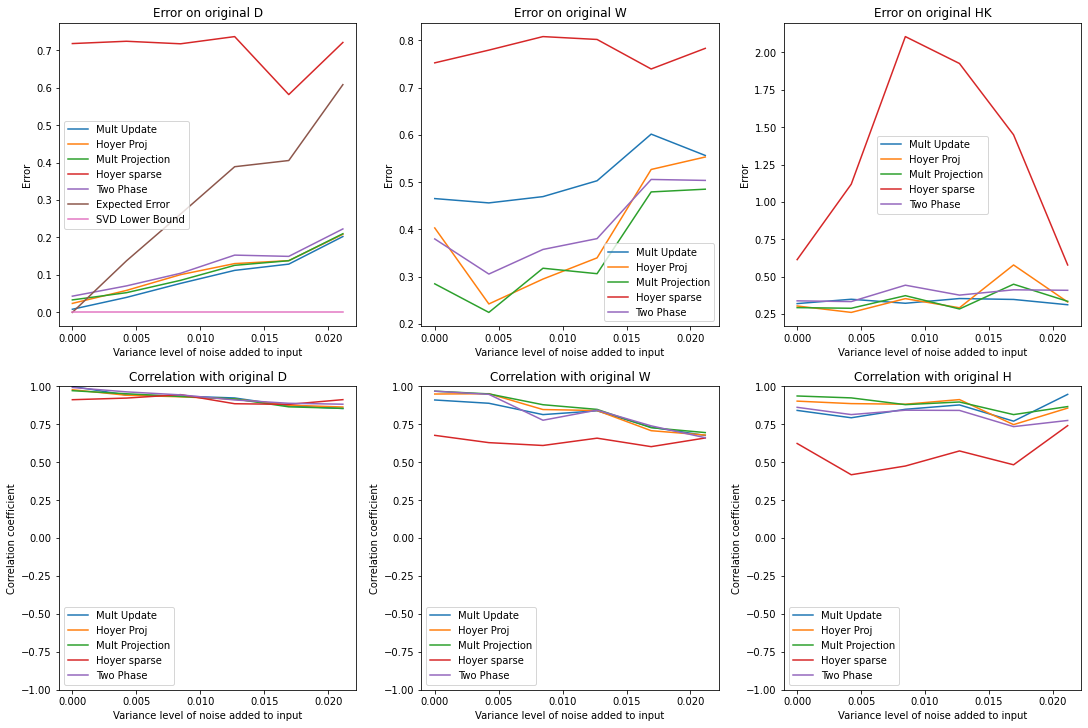

In [129]:
noise_alg_err, noise_alg_corr = test_parameters(gendata, var_tests, K_real, vary = "noise")
plotter2(noise_alg_err, noise_alg_corr, "Variance level of noise added to input")

In [122]:
beta_tests = [1,2,3,4,5,6,7]

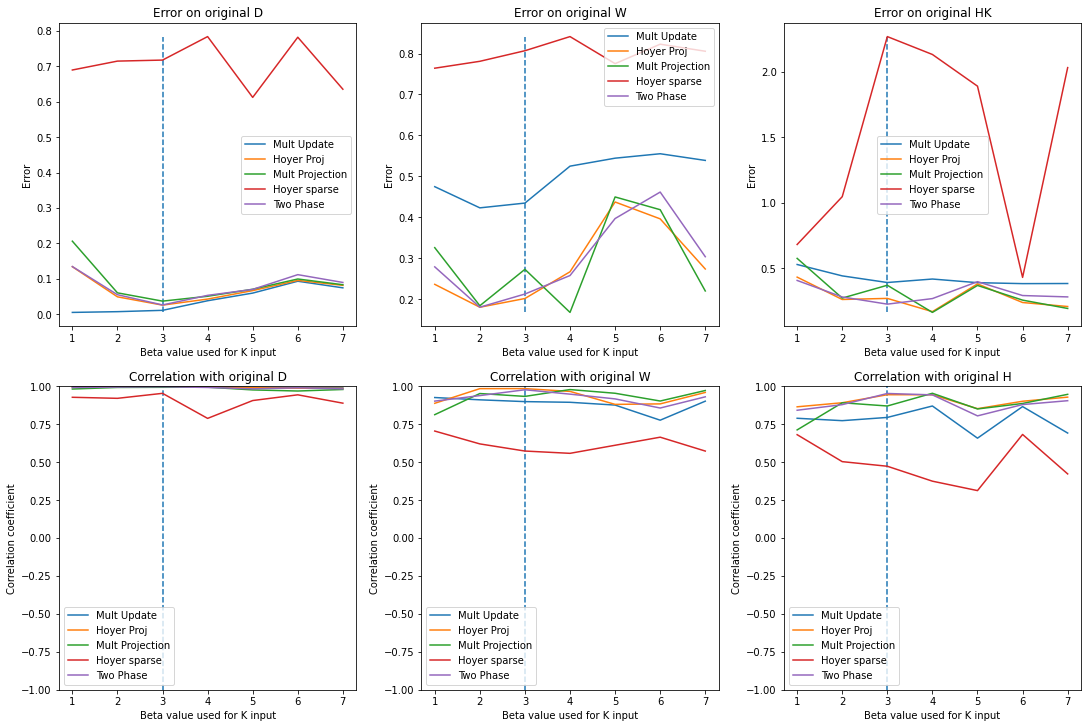

In [123]:
beta_alg_err, beta_alg_corr = test_parameters(gendata, beta_tests, K_real, vary = "beta", Lapl = state_L)
plotter2(beta_alg_err, beta_alg_corr, "Beta value used for K input", v_line = beta_real)

In [124]:
spar_tests = [0.25,0.5,0.75,0.8, 0.85, 0.9]

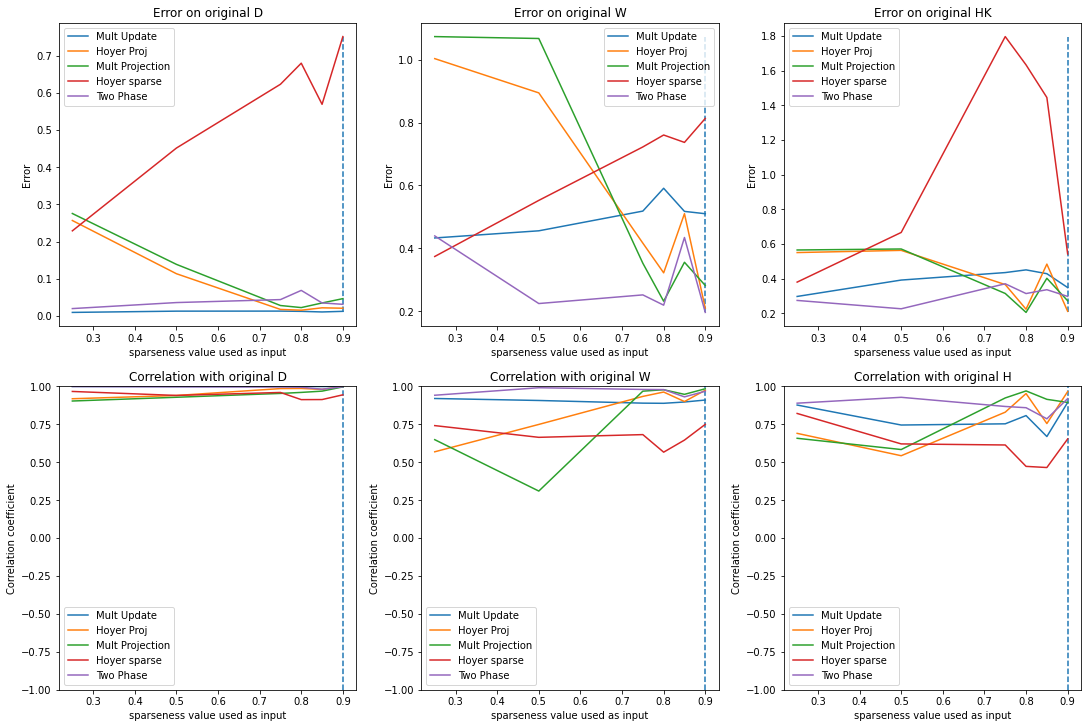

In [125]:
spar_alg_err, spar_alg_corr = test_parameters(gendata, spar_tests, K_real, vary = "sparseness")
plotter2(spar_alg_err, spar_alg_corr, "sparseness value used as input", v_line = 0.9)

In [126]:
rank_tests = [2,3,4,5,6,7]

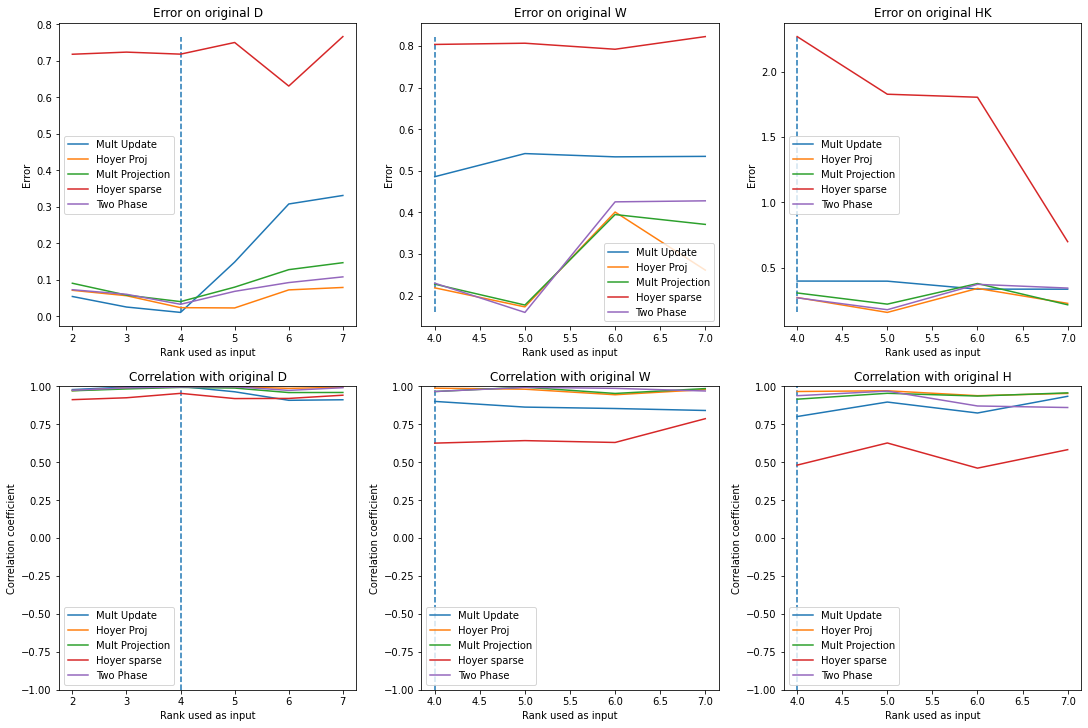

In [127]:
rank_alg_err, rank_alg_corr = test_parameters(gendata, rank_tests, K_real, vary = "rank")
plotter2(rank_alg_err, rank_alg_corr, "Rank used as input", v_line = 4)